# Granger causality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

import re



In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

from sklearn.metrics import mean_absolute_percentage_error


def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [3]:
def grangers_causation_matrix(data, variables, verbose=False, maxlag = 12):    
    """Check Granger Causality matrix. 
    The rows are restponse and columns are predictors.
    P-Values < 0.05, implies that the X does not cause Y to be rejected.

    data      : dataframe containing the time series variables
    variables : columns.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=verbose)
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]
            if not verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [ ]:
# we tried to descibe the dynamics of time series at different points but there can be different factors that are not directly known
# we want to include predictor variables

# Granger causality - whether one time-series is usefull in predicting another one


In [4]:
dfSamples = pd.read_csv("../Lab8/Wage and Inflation data/Mehra.csv", index_col = 0, parse_dates=True)
dfSamples.index.freq = 'QS'
dfSamples

,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-01-01,1606.4,1608.3,47.5,36.9,37.4,26.9,32.3,23.1
1959-04-01,1637.0,1622.2,47.5,37.4,37.5,27.0,32.2,23.4
1959-07-01,1629.5,1636.2,48.7,37.6,37.6,27.1,32.4,23.4
1959-10-01,1643.4,1650.3,48.8,37.7,37.8,27.1,32.5,23.8
1960-01-01,1671.6,1664.6,49.1,37.8,37.8,27.2,32.4,23.8
...,...,...,...,...,...,...,...,...
1988-07-01,4042.7,3971.9,179.6,131.5,124.9,106.2,123.5,92.8
1988-10-01,4069.4,3995.8,181.3,133.3,126.2,107.3,124.9,92.9
1989-01-01,4106.8,4019.9,184.1,134.8,127.7,109.5,126.6,94.0


<AxesSubplot:xlabel='date'>

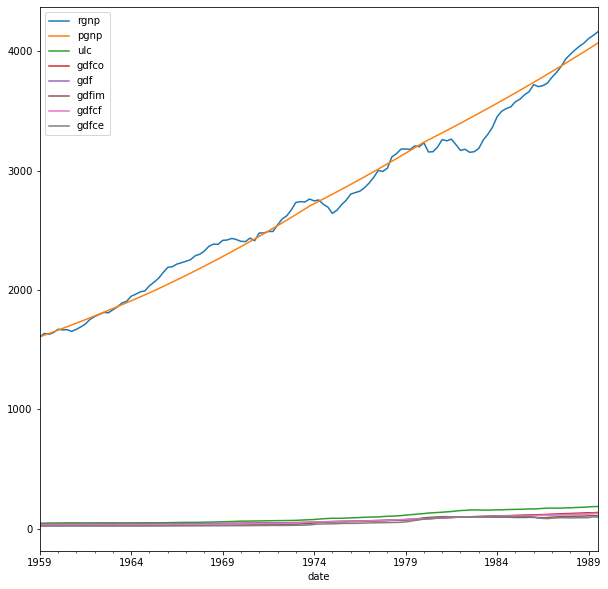

In [5]:
fig, ax = plt.subplots(1, figsize=(10,10))
dfSamples['rgnp'].plot(legend = True)
dfSamples['pgnp'].plot(ax=ax, legend = True)
dfSamples['ulc'].plot(ax=ax, legend = True)
dfSamples['gdfco'].plot(ax=ax, legend = True)
dfSamples['gdf'].plot(ax=ax, legend = True)
dfSamples['gdfim'].plot(ax=ax, legend = True)
dfSamples['gdfcf'].plot(ax=ax, legend = True)
dfSamples['gdfce'].plot(ax=ax, legend = True)

### Time series differencing to obtain stationary statistics and to make Granger causaliy test. In order to see that we check the Augmented Dickey–Fuller test again.


test:  rgnp
p_value = 0.9886037114305949
test:  pgnp
p_value = 0.9964612064726062
test:  ulc
p_value = 0.997099172882968
test:  gdfco
p_value = 0.9870138472785789
test:  gdf
p_value = 0.9953249001658118
test:  gdfim
p_value = 0.9386740229058363
test:  gdfcf
p_value = 0.998051164027281
test:  gdfce
p_value = 0.8144015307501952


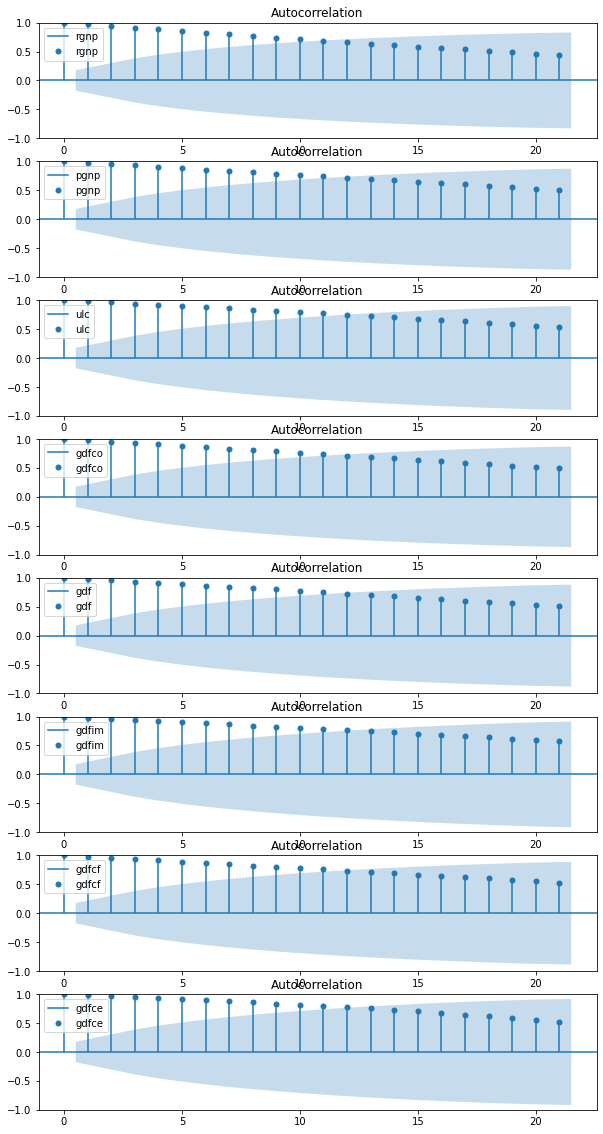

In [6]:
fig, ax = plt.subplots(len(dfSamples.columns), figsize = (10,20))
for i,col in enumerate(dfSamples.columns):
    print("test: ", col)
    print(f"p_value = {adfuller(dfSamples[col])[1]}")
    plot_acf(dfSamples[col], ax = ax[i], label = col)
    ax[i].legend()

In [8]:
dfSamples2 = dfSamples.copy()
orders = []
for i,col in enumerate(dfSamples.columns):
    print("test: ", col)
    model = auto_arima(dfSamples[col], seasonal = False, m = 1, trace = True, verbose=False)#.summary()
    print("\n\n-----------------------------------------------------------------\n\n")
    order = model.get_params()['order']
    d=order[1]
    print(f"differencing order is d={d}")
    orders.append(d)

test:  rgnp
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1149.375, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1156.412, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1147.271, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1150.510, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1211.180, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1145.911, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1147.563, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1147.412, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1147.085, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1149.561, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1158.542, Time=0.05 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.375 seconds


-----------------------------------------------------------------


differencing order is d=1
test:  pgnp
Performing stepwise search to mini

In [9]:
orders[-1] = 2
maxOrder = np.max(orders)
ordersDic = {dfSamples.columns[i]:orders[i] for i in range(len(orders))}
print(f'max order is {maxOrder}')
dfSamples2 = dfSamples.copy()
for i,col in enumerate(dfSamples.columns):
    tmp = dfSamples[col]
    ord = int(orders[i])
    for j in range(ord):
        tmp = difference(tmp)
    tmp = list(tmp)
    for j in range(ord):
        tmp = [np.nan] + tmp
    dfSamples2[col] = np.array(tmp)

dfSamples2 = dfSamples2.dropna()
dfSamples2

max order is 2


,rgnp,pgnp,ulc,gdfco,gdf,gdfim,gdfcf,gdfce
date,,,,,,,,
1959-07-01,-7.5,0.1,1.2,-3.000000e-01,0.0,0.1,0.3,-0.3
1959-10-01,13.9,0.1,-1.1,-1.000000e-01,0.1,0.0,-0.1,0.4
1960-01-01,28.2,0.2,0.2,-7.105427e-15,-0.2,0.1,-0.2,-0.4
1960-04-01,-4.8,0.1,0.2,1.000000e-01,0.2,0.2,0.5,0.1
1960-07-01,1.6,0.1,-0.1,-1.000000e-01,-0.1,0.0,-0.3,0.1
...,...,...,...,...,...,...,...,...
1988-07-01,32.0,0.2,-2.1,-4.000000e-01,0.2,0.1,0.9,-0.3
1988-10-01,26.7,0.1,0.8,6.000000e-01,-0.3,1.1,-1.1,-0.4
1989-01-01,37.4,0.2,1.1,-3.000000e-01,0.2,2.2,0.3,1.0


In [10]:
ordersDic
# order of gdfce shall be 2 or more

{'rgnp': 1,
 'pgnp': 2,
 'ulc': 2,
 'gdfco': 2,
 'gdf': 2,
 'gdfim': 1,
 'gdfcf': 2,
 'gdfce': 2}

Check the test again for stationarity

<AxesSubplot:xlabel='date'>

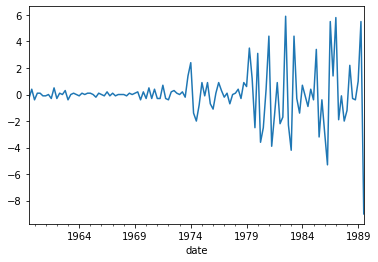

In [11]:
dfSamples2['gdfce'].plot()

test:  rgnp
p_value = 3.3385082936364718e-06
test:  pgnp
p_value = 2.6204782825958454e-20
test:  ulc
p_value = 1.698194036505408e-14
test:  gdfco
p_value = 2.4994349960269606e-14
test:  gdf
p_value = 0.00039702611077686476
test:  gdfim
p_value = 0.0005850011668710128
test:  gdfcf
p_value = 2.1400722424590324e-10
test:  gdfce
p_value = 0.00032807186699190094


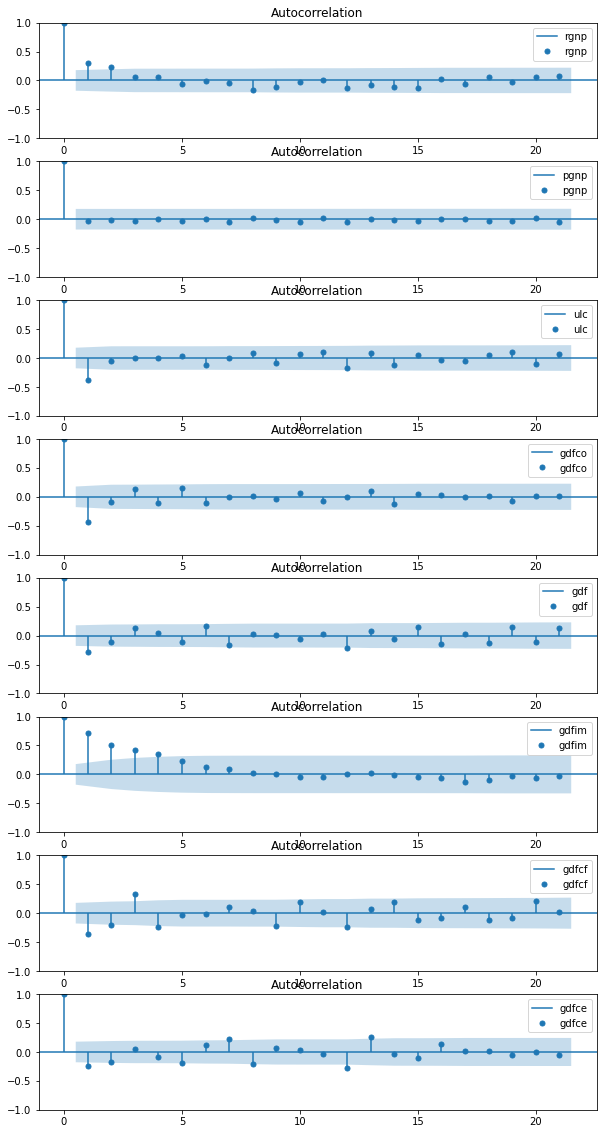

In [12]:
fig, ax = plt.subplots(len(dfSamples2.columns), figsize = (10,20))
for i,col in enumerate(dfSamples2.columns):
    print("test: ", col)
    print(f"p_value = {adfuller(dfSamples2[col])[1]}")
    plot_acf(dfSamples2[col], ax = ax[i], label = col)
    ax[i].legend()


### We would like to check whether the information between different datasets can help predict the other ones

In [13]:
granger = grangers_causation_matrix(dfSamples2, dfSamples2.columns, False)
granger

Y = rgnp, X = rgnp, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Y = pgnp, X = rgnp, P Values = [0.7618, 0.1511, 0.2545, 0.3159, 0.4582, 0.5171, 0.5985, 0.0676, 0.051, 0.0504, 0.0461, 0.007]
Y = ulc, X = rgnp, P Values = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Y = gdfco, X = rgnp, P Values = [0.9136, 0.4359, 0.7276, 0.3431, 0.2975, 0.328, 0.0458, 0.0603, 0.1001, 0.0361, 0.0161, 0.0079]
Y = gdf, X = rgnp, P Values = [0.2351, 0.2986, 0.181, 0.1191, 0.1928, 0.1597, 0.2463, 0.3125, 0.4089, 0.0308, 0.0348, 0.1099]
Y = gdfim, X = rgnp, P Values = [0.4785, 0.6606, 0.8615, 0.0861, 0.0712, 0.1403, 0.0828, 0.1323, 0.1811, 0.2483, 0.3231, 0.18]
Y = gdfcf, X = rgnp, P Values = [0.7522, 0.7968, 0.4188, 0.0653, 0.0173, 0.0015, 0.0051, 0.0067, 0.0055, 0.0016, 0.0033, 0.0059]
Y = gdfce, X = rgnp, P Values = [0.8134, 0.7185, 0.4338, 0.003, 0.0079, 0.0147, 0.0795, 0.0957, 0.0919, 0.0879, 0.121, 0.0225]
Y = rgnp, X = pgnp, P Values = [0.8874, 0.8382, 0.9357

,rgnp_x,pgnp_x,ulc_x,gdfco_x,gdf_x,gdfim_x,gdfcf_x,gdfce_x
rgnp_y,1.0000,0.0215,0.0003,0.0684,0.0017,0.1598,0.0010,0.0418
pgnp_y,0.0070,1.0000,0.4533,0.1941,0.0178,0.0001,0.0461,0.0798
ulc_y,0.0000,0.0006,1.0000,0.5501,0.0000,0.0861,0.0008,0.0013
gdfco_y,0.0079,0.0576,0.0003,1.0000,0.0035,0.0008,0.1012,0.0010
gdf_y,0.0308,0.0000,0.0766,0.0127,1.0000,0.0023,0.0569,0.0000
gdfim_y,0.0712,0.0284,0.0141,0.0207,0.0002,1.0000,0.0004,0.0556
gdfcf_y,0.0015,0.0000,0.1149,0.8100,0.0498,0.0069,1.0000,0.0031
gdfce_y,0.0030,0.1089,0.0010,0.0825,0.0024,0.0005,0.0000,1.0000


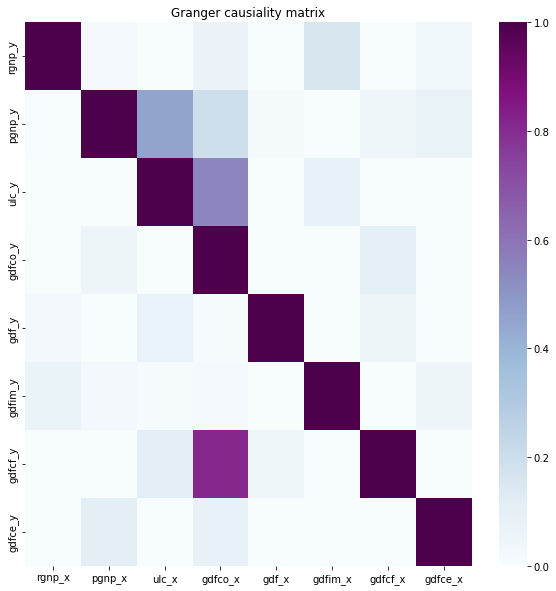

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
fig, ax = plt.subplots(1, figsize = (10,10))
disp = sns.heatmap(granger, fmt='', cmap='BuPu', ax = ax)
ax.set_title("Granger causiality matrix")
plt.show()